# Machine Learning Final Project: Sentiment Analysis (Fall 2024)

**Group Members**

* Amit Sarvate (100794129)
* Nirujan Velvarathan (100706828)


**Overview**

* We aim to classify movie reviews into positive or negative sentiments using a large, popular dataset containing 50,000 instances. 
* To achieve this, we will experiment with three different network architectures: 
    * a Feedforward Neural Network with pre-trained embeddings, 
    * a Convolutional Neural Network (CNN), 
    * and a Gated Recurrent Unit (GRU). 
* The goal is to compare their performance on sentiment classification and identify the most effective model. 
* Additionally, we will develop an application where users can input a review and receive a sentiment prediction.

### Importing External Libraries

In order to preprocess data as well as build, train and test our models - we will require various different essential ML libraries including pandas, sklearn, torch, and keras

---

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import LabelEncoder
import models
from importlib import reload
import time
from sklearn.metrics import precision_score, recall_score, f1_score
import json


# 1. Loading Dataset and Processing Data

In [2]:
#Data Processing

# Load dataset
dataset = pd.read_csv("data/IMDB Dataset.csv")

# Preprocess data
dataset['sentiment'] = dataset['sentiment'].map({'positive': 1, 'negative': 0})
reviews = dataset['review'].values
sentiments = dataset['sentiment'].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(reviews, sentiments, test_size=0.2, random_state=42)

# Tokenizer and sequence preparation
from collections import Counter
from itertools import chain

# Tokenizer class
def build_vocab(sentences, max_words=10000):
    words = chain.from_iterable(sentence.split() for sentence in sentences)
    most_common = Counter(words).most_common(max_words - 2)  # Reserve 2 for padding/unknown
    vocab = {word: idx + 2 for idx, (word, _) in enumerate(most_common)}
    vocab['<PAD>'] = 0
    vocab['<UNK>'] = 1
    return vocab

vocab = build_vocab(X_train)
def tokenize(sentences, vocab):
    return [[vocab.get(word, vocab['<UNK>']) for word in sentence.split()] for sentence in sentences]

X_train_seq = tokenize(X_train, vocab)
X_test_seq = tokenize(X_test, vocab)

# Pad sequences
def pad_sequences(sequences, maxlen):
    return pad_sequence([torch.tensor(seq[:maxlen]) for seq in sequences], batch_first=True, padding_value=0)

max_len = 100
X_train_pad = pad_sequences(X_train_seq, max_len)
X_test_pad = pad_sequences(X_test_seq, max_len)

# Convert to tensors
X_train_pad = torch.tensor(X_train_pad, dtype=torch.long)
X_test_pad = torch.tensor(X_test_pad, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Dataset and DataLoader class
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = SentimentDataset(X_train_pad, y_train)
test_dataset = SentimentDataset(X_test_pad, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

C:\Users\Nirujan\AppData\Local\Temp\ipykernel_17932\1492371365.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_pad = torch.tensor(X_train_pad, dtype=torch.long)
C:\Users\Nirujan\AppData\Local\Temp\ipykernel_17932\1492371365.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_pad = torch.tensor(X_test_pad, dtype=torch.long)


# Evaluating and Training Model Functions

In [3]:
def train_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)  # Remove .float() for inputs to the embedding layer
            loss = criterion(outputs, y_batch)
            loss.backward()
            """for name, param in model.named_parameters():
                if param.requires_grad:
                    print(f"{name}: {param.grad}")"""
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")


def evaluate_metrics(model, test_loader):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = torch.sigmoid(model(X_batch))
            predictions = (outputs > 0.5).int()
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # Compute metrics
    accuracy = sum(np.array(all_predictions) == np.array(all_labels)) / len(all_labels)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    return accuracy, precision, recall, f1

# Initialize Models

In [4]:
#Initialization

vocab_size = len(vocab)
embed_dim = 100
hidden_dim = 128
output_dim = 1  # Binary classification
num_filters = 128
kernel_sizes = [3, 4, 5]
num_layers = 1
max_len = 100

# Model initialization
reload(models)
modelFNN = models.FeedforwardNeuralNetwork(vocab_size, embed_dim, hidden_dim, output_dim, max_len)
modelCNN = models.ConvolutionalNeuralNetwork(vocab_size, embed_dim, num_filters, kernel_sizes, output_dim)
modelGRU = models.GatedRecurrentUnit(vocab_size, embed_dim, hidden_dim, num_layers, output_dim)

c:\Users\Nirujan\Documents\GitHub\sentiment-analysis-ml\new_env\lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


# Training Models

## Feed Forward Neural Network

In [5]:
#FNN
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(modelFNN.parameters(), lr=0.001)
start_time = time.time()
train_model(modelFNN, train_loader, criterion, optimizer, epochs=5)
fnn_training_time = time.time() - start_time


Epoch 1/5, Loss: 0.6345
Epoch 2/5, Loss: 0.3351
Epoch 3/5, Loss: 0.0693
Epoch 4/5, Loss: 0.0264
Epoch 5/5, Loss: 0.0274


## CNN

In [6]:

# Train and evaluate CNN
optimizer = torch.optim.AdamW(modelCNN.parameters(), lr=0.001)
start_time = time.time()
train_model(modelCNN, train_loader, criterion, optimizer, epochs=5)
cnn_training_time = time.time() - start_time


Epoch 1/5, Loss: 0.6180
Epoch 2/5, Loss: 0.4727
Epoch 3/5, Loss: 0.3887
Epoch 4/5, Loss: 0.3250
Epoch 5/5, Loss: 0.2706


## GRU

In [7]:
# Train and evaluate GRU
optimizer = torch.optim.AdamW(modelGRU.parameters(), lr=0.001)
start_time = time.time()
train_model(modelGRU, train_loader, criterion, optimizer, epochs=5)
gru_training_time = time.time() - start_time

Epoch 1/5, Loss: 0.6985
Epoch 2/5, Loss: 0.6973
Epoch 3/5, Loss: 0.6971
Epoch 4/5, Loss: 0.6975
Epoch 5/5, Loss: 0.6976


# Evaluation

In [8]:
# Evaluation
results = {"Model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1-Score": [], "Training Time (s)": []}

#FNN

fnn_accuracy, fnn_precision, fnn_recall, fnn_f1 = evaluate_metrics(modelFNN, test_loader)

results["Model"].append("FNN")
results["Accuracy"].append(fnn_accuracy)
results["Precision"].append(fnn_precision)
results["Recall"].append(fnn_recall)
results["F1-Score"].append(fnn_f1)
results["Training Time (s)"].append(fnn_training_time)


In [9]:


cnn_accuracy, cnn_precision, cnn_recall, cnn_f1 = evaluate_metrics(modelCNN, test_loader)

# Add CNN results to the table
results["Model"].append("CNN")
results["Accuracy"].append(cnn_accuracy)
results["Precision"].append(cnn_precision)
results["Recall"].append(cnn_recall)
results["F1-Score"].append(cnn_f1)
results["Training Time (s)"].append(cnn_training_time)


In [10]:


gru_accuracy, gru_precision, gru_recall, gru_f1 = evaluate_metrics(modelGRU, test_loader)

# Add GRU results to the table
results["Model"].append("GRU")
results["Accuracy"].append(gru_accuracy)
results["Precision"].append(gru_precision)
results["Recall"].append(gru_recall)
results["F1-Score"].append(gru_f1)
results["Training Time (s)"].append(gru_training_time)

# Convert results to a DataFrame

results_df = pd.DataFrame(results)
print(results_df)

  Model  Accuracy  Precision    Recall  F1-Score  Training Time (s)
0   FNN    0.7500   0.746361  0.763247  0.754710         112.920031
1   CNN    0.8106   0.791366  0.847589  0.818513         176.118549
2   GRU    0.4953   0.498607  0.284183  0.362028         891.759544


# Visualization

---

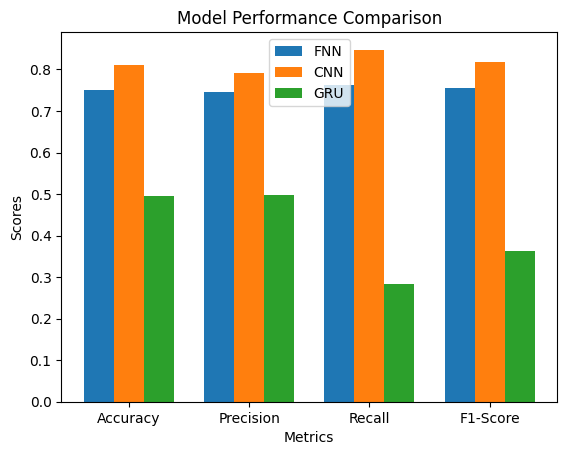

In [11]:
#Visualization
import matplotlib.pyplot as plt
import numpy as np

# Bar Plot for Metrics
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
x = np.arange(len(metrics))  # Metric indices
width = 0.25  # Bar width

# Extract metrics for each model
fnn_metrics = [fnn_accuracy, fnn_precision, fnn_recall, fnn_f1]
cnn_metrics = [cnn_accuracy, cnn_precision, cnn_recall, cnn_f1]
gru_metrics = [gru_accuracy, gru_precision, gru_recall, gru_f1]

# Plot
plt.bar(x - width, fnn_metrics, width, label="FNN")
plt.bar(x, cnn_metrics, width, label="CNN")
plt.bar(x + width, gru_metrics, width, label="GRU")

# Formatting
plt.xlabel("Metrics")
plt.ylabel("Scores")
plt.title("Model Performance Comparison")
plt.xticks(x, metrics)
plt.legend()
plt.show()

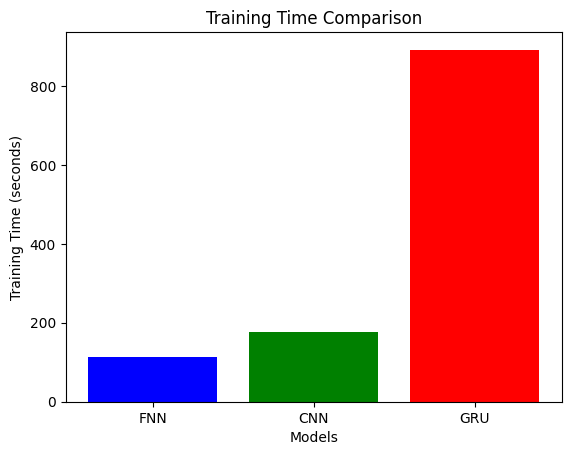

In [12]:
# Bar Plot for Training Time
training_times = [fnn_training_time, cnn_training_time, gru_training_time]
models = ["FNN", "CNN", "GRU"]

plt.bar(models, training_times, color=["blue", "green", "red"])
plt.xlabel("Models")
plt.ylabel("Training Time (seconds)")
plt.title("Training Time Comparison")
plt.show()

# Saving Models for App

In [13]:
torch.save(modelFNN.state_dict(), "fnn_sentiment_model.pth")
torch.save(modelCNN.state_dict(), "cnn_sentiment_model.pth")
torch.save(modelGRU.state_dict(), "gru_sentiment_model.pth")


In [14]:
with open("vocab.json", "w") as f:
    json.dump(vocab, f)